# Blood Cell Recognition CNN with ResNet

Hemopathology (hemo means blood, pathology means disease), is the study of studying diseases through blood cells. Abnormal blood cell structure, the level of the number of blood cells, and so on, are some of the factors that can be used to identify some diseases.

Some diseases, such as leukemia, dengue fever, thalassemia, malaria, not to forget the most infamous example of recent times thatt is CoViD-19, have marked changes in the white blood cell count. This is because some types of white blood cells can only fight certain types of disease. Changes in the number of these cells can be used to identify the disease. That way, the use of CNN in identifying blood cells can be useful so that the process of identifying changes in the number of blood cells can be done quickly and accurately using deep learning.

# Import Library

Importing all libraries for Deep Learning. The most important library for us is TensorFlow.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
  Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [3]:
# Defining desired image size
IMAGE_SIZE = [224, 224]

# Defining training parameters (These can be adjusted for more accuracy)
epochs = 20
batch_size = 128

In [4]:
# Define dataset
train_path = '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
valid_path = '../input/blood-cells/dataset2-master/dataset2-master/images/TEST'

In [5]:
# Useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [6]:
# Useful for getting number of classes
folders = glob(train_path + '/*')

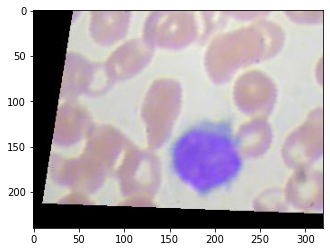

In [7]:
# Look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

# Making Architecture

Here we will use the slightly modified ResNet architecture to suit the dataset.

1. Defining Identity Block
2. Defining Convolutional Block
3. Defining custom ResNet tailored to this dataset

In [8]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), 
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), 
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [9]:
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
    )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
# Custom ResNet layer
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

2022-06-21 10:48:00.877820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:01.011042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:01.011878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:01.013016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
x = Flatten()(x)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# Create a model object
model = Model(inputs=i, outputs=prediction)

In [13]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
# Tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [15]:
# Create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [16]:
# Test generator to see how it works and some other useful things

# Get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 1.0


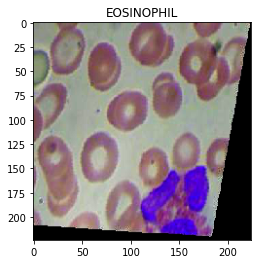

In [17]:
# Check image generation quality - Should NOT be a strangely colored image
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [18]:
# Create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [19]:
# Fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor='loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
  ]
)

2022-06-21 10:48:16.680318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-21 10:48:21.868731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - 210s 3s/step - loss: 7.5023 - accuracy: 0.2715 - val_loss: 3.1564 - val_accuracy: 0.2619
Epoch 2/20
77/77 [==============================] - 137s 2s/step - loss: 2.1576 - accuracy: 0.3970 - val_loss: 1.9431 - val_accuracy: 0.3692
Epoch 3/20
77/77 [==============================] - 136s 2s/step - loss: 1.5232 - accuracy: 0.5922 - val_loss: 1.6841 - val_accuracy: 0.4675
Epoch 4/20
77/77 [==============================] - 136s 2s/step - loss: 1.0349 - accuracy: 0.7233 - val_loss: 2.5984 - val_accuracy: 0.4601
Epoch 5/20
77/77 [==============================] - 137s 2s/step - loss: 0.5821 - accuracy: 0.8233 - val_loss: 2.7116 - val_accuracy: 0.5370
Epoch 6/20
77/77 [==============================] - 137s 2s/step - loss: 0.5507 - accuracy: 0.8615 - val_loss: 1.9247 - val_accuracy: 0.6789
Epoch 7/20
77/77 [==============================] - 136s 2s/step - loss: 0.3415 - accuracy: 0.9051 - val_loss: 1.1465 - val_accuracy: 0.7623
Epoch 8/20
77/77 [======

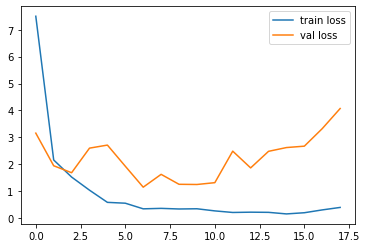

In [20]:
# Loss plotting
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

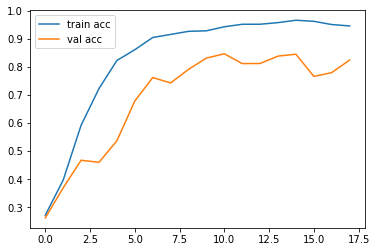

In [21]:
# Accuracies plotting
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [22]:
def get_confusion_matrix(data_path, N):
  # We need to see the data in the same order for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [23]:
# Confusion Matrix of training data
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[2209   12    0  276]
 [   0 2483    0    0]
 [   1  172 2235   70]
 [   3   12    0 2484]]


In [24]:
# Confusion Matrix of testing data
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[465   5   0 153]
 [  0 609   0  11]
 [  1  16 443 160]
 [ 39   5   0 580]]


In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[2209   12    0  276]
 [   0 2483    0    0]
 [   1  172 2235   70]
 [   3   12    0 2484]]


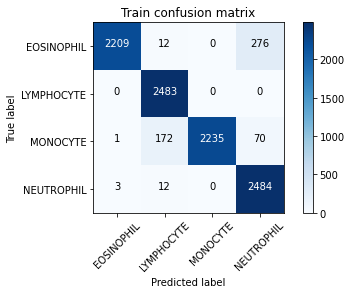

In [26]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [27]:
np.trace(cm) / cm.sum()

0.9451642060861706

Confusion matrix, without normalization
[[465   5   0 153]
 [  0 609   0  11]
 [  1  16 443 160]
 [ 39   5   0 580]]


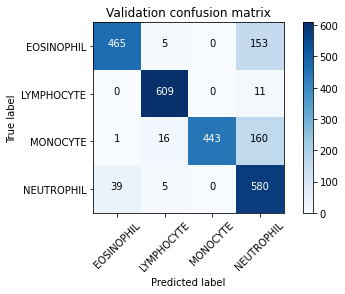

In [28]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [29]:
np.trace(valid_cm) / valid_cm.sum()

0.8431845597104946